### Install packages

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup Kaggle API Key

In [ ]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
import json
kaggle_username = "FILL_IN_USERNAME"
kaggle_key = "FILL_IN_KEY"

with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [ ]:
!kaggle competitions download -c bike-sharing-demand
!unzip -o bike-sharing-demand.zip

In [1]:
import pandas as pd
from autogluon.tabular import TabularPredictor, TabularDataset

In [2]:
train = pd.read_csv("/bike-sharing-demand/train.csv", parse_dates=["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [4]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [5]:
label = "count"
train[label].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

In [6]:
test = pd.read_csv("/bike-sharing-demand/test.csv", parse_dates=["datetime"])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [7]:
test.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

In [8]:
submission = pd.read_csv("/bike-sharing-demand/sampleSubmission.csv", parse_dates=["datetime"])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [9]:
# Train multiple models
predictor = TabularPredictor(
    label="count", 
    learner_kwargs={"ignored_columns": ["casual", "registered"]}, 
    eval_metric="root_mean_squared_error").fit(train, time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20230315_195150/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230315_195150/"
AutoGluon Version:  0.7.0
Python Version:     3.8.16
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.2.0: Fri Nov 11 02:03:51 PST 2022; root:xnu-8792.61.2~4/RELEASE_ARM64_T6000
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem

[1000]	valid_set's rmse: 131.684
[2000]	valid_set's rmse: 130.67
[3000]	valid_set's rmse: 130.626
[1000]	valid_set's rmse: 135.592
[1000]	valid_set's rmse: 133.481
[2000]	valid_set's rmse: 132.323
[3000]	valid_set's rmse: 131.618
[4000]	valid_set's rmse: 131.443
[5000]	valid_set's rmse: 131.265
[6000]	valid_set's rmse: 131.277
[7000]	valid_set's rmse: 131.443
[1000]	valid_set's rmse: 128.503
[2000]	valid_set's rmse: 127.654
[3000]	valid_set's rmse: 127.227
[4000]	valid_set's rmse: 127.105
[1000]	valid_set's rmse: 134.135
[2000]	valid_set's rmse: 132.272
[3000]	valid_set's rmse: 131.286
[4000]	valid_set's rmse: 130.752
[5000]	valid_set's rmse: 130.363
[6000]	valid_set's rmse: 130.509
[1000]	valid_set's rmse: 136.168
[2000]	valid_set's rmse: 135.138
[3000]	valid_set's rmse: 135.029
[1000]	valid_set's rmse: 134.061
[2000]	valid_set's rmse: 133.034
[3000]	valid_set's rmse: 132.182
[4000]	valid_set's rmse: 131.997
[5000]	valid_set's rmse: 131.643
[6000]	valid_set's rmse: 131.504
[7000]	vali

	-131.4609	 = Validation score   (-root_mean_squared_error)
	141.37s	 = Training   runtime
	0.41s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 256.28s of the 456.35s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 130.818
[1000]	valid_set's rmse: 133.204
[1000]	valid_set's rmse: 130.928
[1000]	valid_set's rmse: 126.846
[1000]	valid_set's rmse: 131.426
[1000]	valid_set's rmse: 133.655
[1000]	valid_set's rmse: 132.155
[1000]	valid_set's rmse: 130.62


	-131.0542	 = Validation score   (-root_mean_squared_error)
	34.65s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 221.22s of the 421.29s of remaining time.
	-116.5439	 = Validation score   (-root_mean_squared_error)
	1.38s	 = Training   runtime
	0.26s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 219.39s of the 419.46s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 6342.
	Ran out of time, early stopping on iteration 6515.
	Ran out of time, early stopping on iteration 6632.
	-130.5163	 = Validation score   (-root_mean_squared_error)
	145.97s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 73.35s of the 273.42s of remaining time.
	-124.5878	 = Validation score   (-root_mean_squared_error)
	0.57s	 = Training   r

[1000]	valid_set's rmse: 59.8826
[2000]	valid_set's rmse: 58.8233
[1000]	valid_set's rmse: 60.0021
[2000]	valid_set's rmse: 59.0459
[1000]	valid_set's rmse: 62.8742
[2000]	valid_set's rmse: 61.5991
[1000]	valid_set's rmse: 64.421
[2000]	valid_set's rmse: 62.6877
[1000]	valid_set's rmse: 58.5712
[2000]	valid_set's rmse: 57.6807
[1000]	valid_set's rmse: 62.7947
[2000]	valid_set's rmse: 61.6058
[1000]	valid_set's rmse: 63.0031
[2000]	valid_set's rmse: 61.9254
[3000]	valid_set's rmse: 61.8673
[4000]	valid_set's rmse: 61.9065
[1000]	valid_set's rmse: 57.8321
[2000]	valid_set's rmse: 57.6018


	-60.0789	 = Validation score   (-root_mean_squared_error)
	77.06s	 = Training   runtime
	0.22s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 121.93s of the 121.93s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-54.8506	 = Validation score   (-root_mean_squared_error)
	16.8s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 105.01s of the 105.01s of remaining time.
	-53.2098	 = Validation score   (-root_mean_squared_error)
	3.74s	 = Training   runtime
	0.29s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 100.85s of the 100.84s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-55.5571	 = Validation score   (-root_mean_squared_error)
	35.08s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L2 ... T

### Review AutoGluon's training run with ranking of models that did the best.

In [10]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -50.656566       1.876720  447.396203                0.000395           0.219581            3       True         20
1   NeuralNetFastAI_BAG_L2  -51.791022       1.300405  442.348044                0.077905          46.513812            2       True         17
2   RandomForestMSE_BAG_L2  -53.209784       1.511695  399.576741                0.289195           3.742508            2       True         14
3     ExtraTreesMSE_BAG_L2  -53.762812       1.509225  396.920301                0.286725           1.086069            2       True         16
4           XGBoost_BAG_L2  -54.780719       1.255514  411.315229                0.033015          15.480997            2       True         18
5          LightGBM_BAG_L2  -54.850588       1.262080  412.636946         

/Users/christina/.pyenv/versions/3.8.16/envs/venv/lib/python3.8/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'Ligh

-50.656565834503645

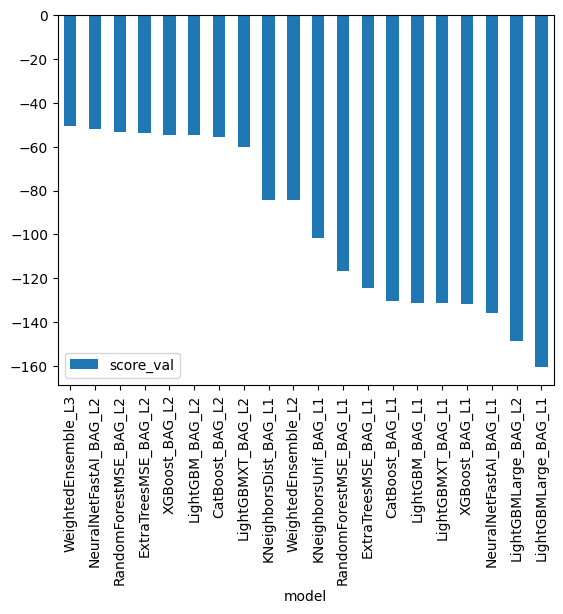

In [11]:
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

In [34]:
initial_best_model_score = predictor.leaderboard(silent=True).score_val[0]
initial_best_model_score

-50.656565834503645

In [35]:
initial_best_model = predictor.leaderboard(silent=True).model[0]
initial_best_model

'WeightedEnsemble_L3'

In [13]:
predictor.feature_importance(data=train)

Computing feature importance via permutation shuffling for 9 features using 5000 rows with 5 shuffle sets...
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has starte

,importance,stddev,p_value,n,p99_high,p99_low
datetime,178.399087,7.728187,4.215367e-07,5,194.311532,162.486643
holiday,-0.145944,0.027156,9.998626e-01,5,-0.090029,-0.201858
season,-0.746015,0.158910,9.997672e-01,5,-0.418818,-1.073213
weather,-1.304814,0.286026,9.997398e-01,5,-0.715881,-1.893746
atemp,-2.746261,0.485692,9.998873e-01,5,-1.746213,-3.746309
windspeed,-4.258928,0.370264,9.999932e-01,5,-3.496549,-5.021307
temp,-4.563552,0.498037,9.999832e-01,5,-3.538086,-5.589017
humidity,-4.976030,0.433769,9.999931e-01,5,-4.082893,-5.869167
workingday,-6.297909,0.661144,9.999856e-01,5,-4.936604,-7.659214


### Create predictions from test dataset

In [25]:
predictions = predictor.predict(test)
predictions.head()

0    25.243507
1    39.236584
2    43.756599
3    46.845642
4    49.248672
Name: count, dtype: float32

In [26]:
predictions.describe()

count    6493.000000
mean       99.180191
std        88.254120
min        -0.940082
25%        20.459064
50%        65.177330
75%       166.824005
max       354.987976
Name: count, dtype: float64

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [27]:
predictions[predictions < 0].count()

6

In [17]:
predictions[predictions < 0] = 0

### Set predictions to submission dataframe, save, and submit

In [18]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [19]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:01<00:00, 131kB/s]
Successfully submitted to Bike Sharing Demand

In [20]:
!chmod 600 /Users/christina/.kaggle/kaggle.json

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [21]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2023-03-15 20:07:22  first raw submission               complete  1.82268      1.82268       
submission_new_hpo.csv       2023-03-08 00:18:14  new features with hyperparameters  complete  0.57948      0.57948       
submission_new_features.csv  2023-03-08 00:16:26  new features                       complete  0.49657      0.49657       
submission_new_hpo.csv       2023-03-07 23:23:12  new features with hyperparameters  complete  0.57948      0.57948       


#### Initial score of 1.79873

array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'holiday'}>],
       [<Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'weather'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'count'}>]], dtype=object)

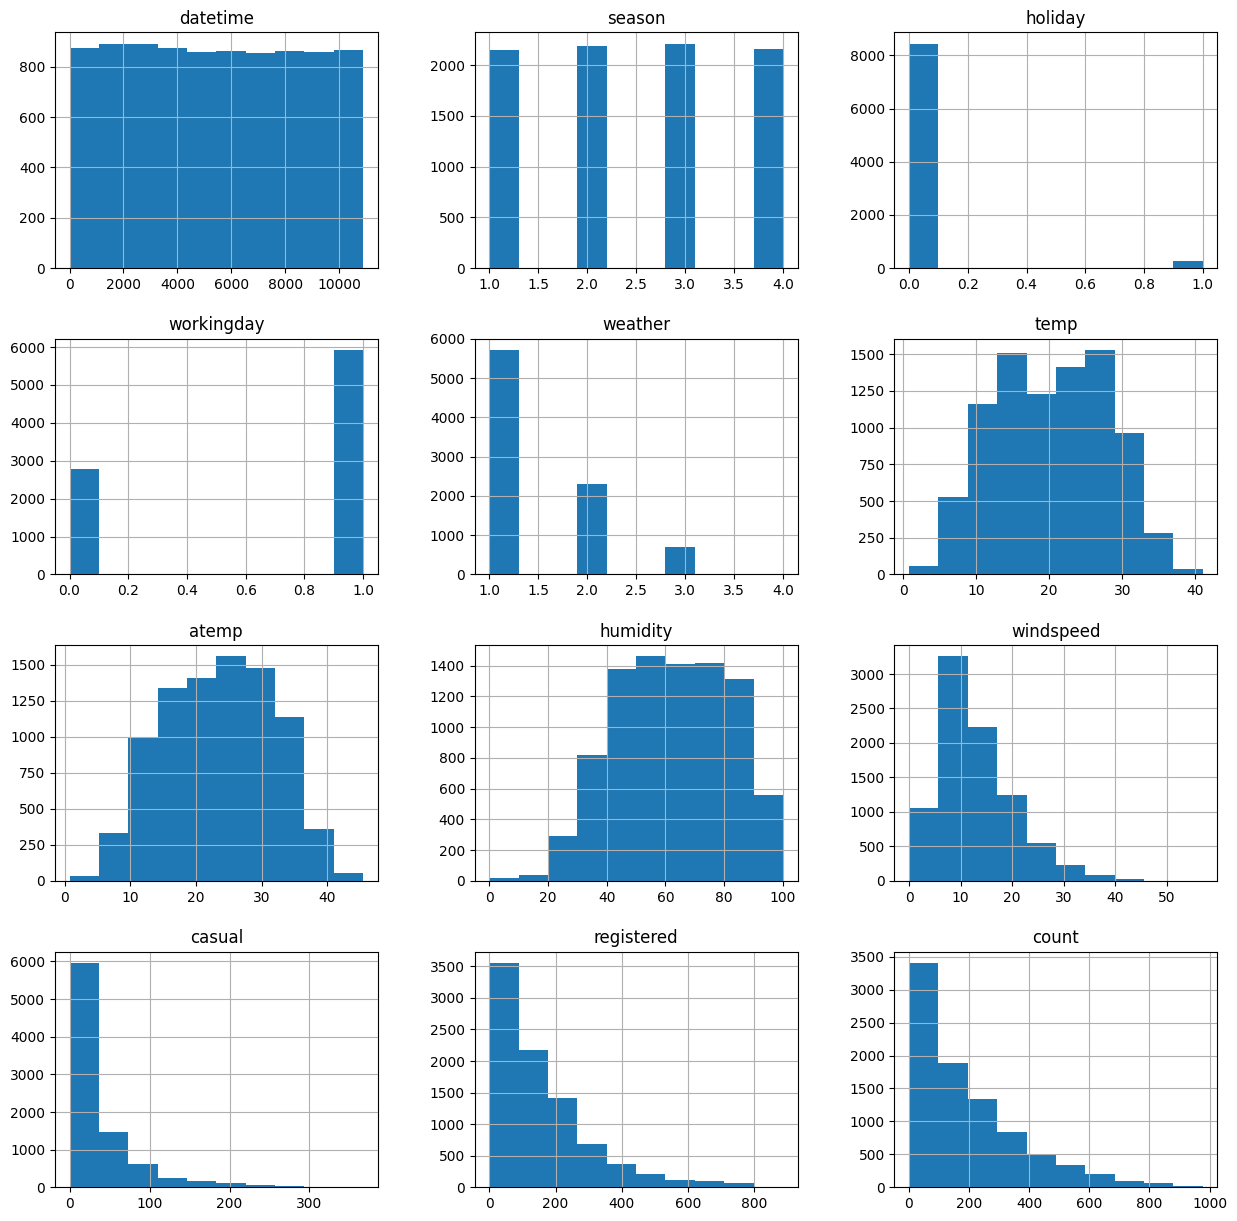

In [80]:
train.hist(figsize=(15, 15))

In [28]:
# New features I
from autogluon.features.generators import DatetimeFeatureGenerator

train_time_gen = DatetimeFeatureGenerator(["month", "day", "hour"])
test_time_gen = DatetimeFeatureGenerator(["month", "day", "hour"])

train_time_feat = train_time_gen.fit_transform(train)
test_time_feat = test_time_gen.fit_transform(test)

train_new_feat = pd.concat([train, train_time_feat], axis=1)
test_new_feat = pd.concat([test, test_time_feat], axis=1)

train_new_feat["year"] = train["datetime"].dt.year
test_new_feat["year"] = test["datetime"].dt.year

train_new_feat = train_new_feat.drop("datetime", axis=1)
test_new_feat = test_new_feat.drop("datetime", axis=1)

train_new_feat.head()

Fitting DatetimeFeatureGenerator...
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
Fitting DatetimeFeatureGenerator...
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,datetime.month,datetime.day,datetime.hour,year
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,1,0,2011
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1,2011
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,1,2,2011
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,1,3,2011
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,1,4,2011


In [29]:
test_new_feat.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime.month,datetime.day,datetime.hour,year
0,1,0,1,1,10.66,11.365,56,26.0027,1,20,0,2011
1,1,0,1,1,10.66,13.635,56,0.0000,1,20,1,2011
2,1,0,1,1,10.66,13.635,56,0.0000,1,20,2,2011
3,1,0,1,1,10.66,12.880,56,11.0014,1,20,3,2011
4,1,0,1,1,10.66,12.880,56,11.0014,1,20,4,2011


## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [30]:
# Transform applicable features into categories II
train_new_feat["season"] = train_new_feat["season"].astype("category")
train_new_feat["weather"] = train_new_feat["weather"].astype("category")
train_new_feat["year"] = train_new_feat["year"].astype("category")
train_new_feat["holiday"] = train_new_feat["holiday"].astype("category")
train_new_feat["workingday"] = train_new_feat["workingday"].astype("category")

test_new_feat["season"] = test_new_feat["season"].astype("category")
test_new_feat["weather"] = test_new_feat["season"].astype("category")
test_new_feat["year"] = test_new_feat["year"].astype("category")
test_new_feat["holiday"] = test_new_feat["holiday"].astype("category")
test_new_feat["workingday"] = test_new_feat["workingday"].astype("category")

In [31]:
train_new_feat.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,datetime.month,datetime.day,datetime.hour,year
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,1,0,2011
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1,2011
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,1,2,2011
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,1,3,2011
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,1,4,2011


array([[<Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>],
       [<Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>],
       [<Axes: title={'center': 'count'}>,
        <Axes: title={'center': 'datetime.month'}>,
        <Axes: title={'center': 'datetime.day'}>],
       [<Axes: title={'center': 'datetime.hour'}>, <Axes: >, <Axes: >]],
      dtype=object)

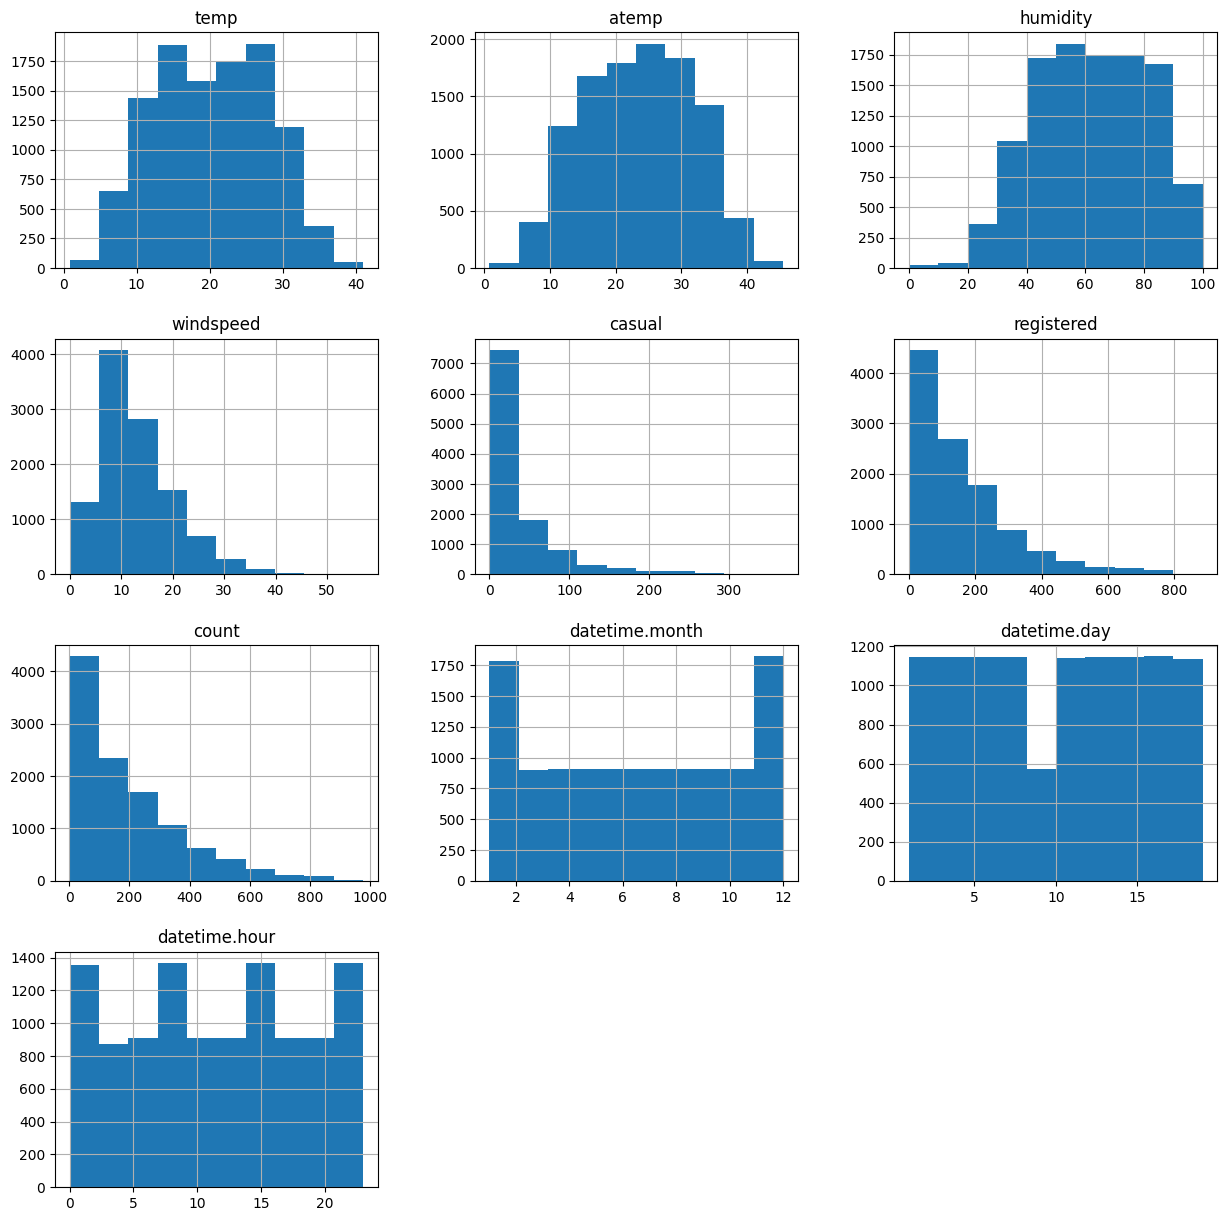

In [32]:
train_new_feat.hist(figsize=(15, 15))

In [33]:
predictor_new_features = TabularPredictor(
    label="count", 
    learner_kwargs={"ignored_columns": ["casual", "registered"]}, 
    eval_metric="root_mean_squared_error").fit(train_new_feat, time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20230315_201158/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230315_201158/"
AutoGluon Version:  0.7.0
Python Version:     3.8.16
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.2.0: Fri Nov 11 02:03:51 PST 2022; root:xnu-8792.61.2~4/RELEASE_ARM64_T6000
Train Data Rows:    10886
Train Data Columns: 14
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem

[1000]	valid_set's rmse: 38.1831
[2000]	valid_set's rmse: 36.3534
[3000]	valid_set's rmse: 35.9682
[4000]	valid_set's rmse: 35.9153
[5000]	valid_set's rmse: 35.8803


	Ran out of time, early stopping on iteration 5219. Best iteration is:
	[4506]	valid_set's rmse: 35.8476


[1000]	valid_set's rmse: 40.2132
[2000]	valid_set's rmse: 38.568
[3000]	valid_set's rmse: 37.959
[4000]	valid_set's rmse: 37.6747
[5000]	valid_set's rmse: 37.4856
[6000]	valid_set's rmse: 37.3
[7000]	valid_set's rmse: 37.1938
[8000]	valid_set's rmse: 37.1756


	Ran out of time, early stopping on iteration 8173. Best iteration is:
	[7760]	valid_set's rmse: 37.1607


[1000]	valid_set's rmse: 38.8445
[2000]	valid_set's rmse: 37.4841
[3000]	valid_set's rmse: 37.2293
[4000]	valid_set's rmse: 37.0479
[5000]	valid_set's rmse: 36.9205
[6000]	valid_set's rmse: 36.8023
[7000]	valid_set's rmse: 36.7757
[8000]	valid_set's rmse: 36.7345
[9000]	valid_set's rmse: 36.7168
[10000]	valid_set's rmse: 36.6887
[1000]	valid_set's rmse: 39.9399
[2000]	valid_set's rmse: 38.5815
[3000]	valid_set's rmse: 38.2467
[4000]	valid_set's rmse: 38.0437
[5000]	valid_set's rmse: 37.9804
[6000]	valid_set's rmse: 38.0078
[1000]	valid_set's rmse: 41.8714
[2000]	valid_set's rmse: 40.1642
[3000]	valid_set's rmse: 39.6496
[4000]	valid_set's rmse: 39.4988
[5000]	valid_set's rmse: 39.449
[6000]	valid_set's rmse: 39.4147
[7000]	valid_set's rmse: 39.3967
[8000]	valid_set's rmse: 39.4487
[1000]	valid_set's rmse: 38.9347
[2000]	valid_set's rmse: 36.8248
[3000]	valid_set's rmse: 36.1627
[4000]	valid_set's rmse: 35.8347
[5000]	valid_set's rmse: 35.6252
[6000]	valid_set's rmse: 35.4707
[7000]	val

	-37.2123	 = Validation score   (-root_mean_squared_error)
	338.26s	 = Training   runtime
	1.02s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 58.35s of the 258.43s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 36.6982


	Ran out of time, early stopping on iteration 1552. Best iteration is:
	[1489]	valid_set's rmse: 36.4247


[1000]	valid_set's rmse: 37.4772


	Ran out of time, early stopping on iteration 1931. Best iteration is:
	[1904]	valid_set's rmse: 36.6443


[1000]	valid_set's rmse: 37.1871


	Ran out of time, early stopping on iteration 2052. Best iteration is:
	[1837]	valid_set's rmse: 36.5583


[2000]	valid_set's rmse: 36.5679
[1000]	valid_set's rmse: 39.3305
[2000]	valid_set's rmse: 38.9471


	Ran out of time, early stopping on iteration 2126. Best iteration is:
	[1840]	valid_set's rmse: 38.909


[1000]	valid_set's rmse: 40.5725


	Ran out of time, early stopping on iteration 1937. Best iteration is:
	[1694]	valid_set's rmse: 40.1458


[1000]	valid_set's rmse: 36.4101
[2000]	valid_set's rmse: 36.0051


	Ran out of time, early stopping on iteration 2361. Best iteration is:
	[2221]	valid_set's rmse: 35.9396


[1000]	valid_set's rmse: 41.5518
[2000]	valid_set's rmse: 41.0615


	Ran out of time, early stopping on iteration 2572. Best iteration is:
	[2494]	valid_set's rmse: 40.9237


[1000]	valid_set's rmse: 36.8879


	-37.8099	 = Validation score   (-root_mean_squared_error)
	53.14s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 4.46s of the 204.54s of remaining time.
	-42.2051	 = Validation score   (-root_mean_squared_error)
	1.03s	 = Training   runtime
	0.26s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 3.02s of the 203.1s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 101.
	Ran out of time, early stopping on iteration 104.
	Ran out of time, early stopping on iteration 104.
	Ran out of time, early stopping on iteration 109.
	Ran out of time, early stopping on iteration 112.
	Ran out of time, early stopping on iteration 123.
	Ran out of time, early stopping on iteration 134.
	Ran out of time, early stopping on iteration 157.
	-55.7388	 = Validation score   (-root_mean_squared_error)
	2.8

In [36]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -35.833622       2.580064  540.976624                0.000230           0.174571            3       True         18
1     ExtraTreesMSE_BAG_L2  -36.045121       2.095387  396.778823                0.285874           0.905934            2       True         13
2      WeightedEnsemble_L2  -36.087402       1.698668  393.092153                0.000204           0.105872            2       True          8
3          CatBoost_BAG_L2  -36.347485       1.826319  412.707847                0.016806          16.834958            2       True         12
4          LightGBM_BAG_L2  -36.498648       1.831804  406.353428                0.022290          10.480539            2       True         10
5   NeuralNetFastAI_BAG_L2  -36.509514       1.903369  447.461320         

/Users/christina/.pyenv/versions/3.8.16/envs/venv/lib/python3.8/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L2': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L2': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'm

In [35]:
predictor_new_features.feature_importance(data=train)

Computing feature importance via permutation shuffling for 12 features using 5000 rows with 5 shuffle sets...
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has start

,importance,stddev,p_value,n,p99_high,p99_low
hour,124.754601,1.691810,4.057467e-09,5,128.238062,121.271141
datetime,106.034625,1.796926,9.893382e-09,5,109.734520,102.334729
workingday,27.693126,0.736189,5.987441e-08,5,29.208949,26.177303
humidity,9.152617,0.517346,1.219765e-06,5,10.217839,8.087394
temp,7.782327,0.543858,2.843553e-06,5,8.902137,6.662517
atemp,4.773322,0.634827,3.667303e-05,5,6.080440,3.466204
weather,3.997250,0.627915,7.072671e-05,5,5.290136,2.704365
day,1.029900,0.105064,1.281773e-05,5,1.246228,0.813572
windspeed,0.537953,0.124654,3.225203e-04,5,0.794618,0.281289
month,0.494616,0.174684,1.592718e-03,5,0.854294,0.134939


<Axes: xlabel='model'>

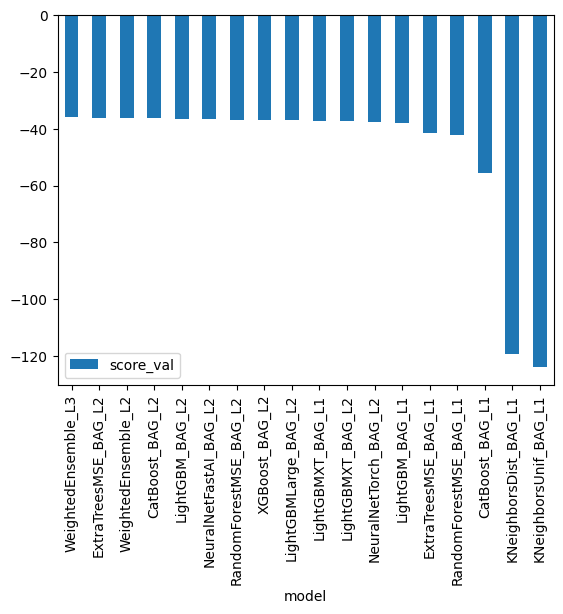

In [37]:
predictor_new_features.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

In [38]:
new_feature_best_model_score = predictor_new_features.leaderboard(silent=True).score_val[0]
new_feature_best_model_score

-35.833622387558044

In [39]:
new_feature_best_model = predictor_new_features.leaderboard(silent=True).model[0]
new_feature_best_model

'WeightedEnsemble_L3'

In [40]:
predictions_new_features = predictor_new_features.predict(test_new_feat)
predictions_new_features.head()

0    13.503189
1     5.495862
2     4.497952
3     4.453490
4     3.808284
Name: count, dtype: float32

In [ ]:
predictions_new_features.describe()

count    6493.000000
mean      177.780884
std       160.791718
min         1.615402
25%        46.582214
50%       139.934586
75%       259.638916
max       878.095520
Name: count, dtype: float64

In [42]:
predictions_new_features[predictions_new_features < 0].count()

0

In [43]:
predictions_new_features[predictions_new_features < 0] = 0

In [44]:
submission_new_features = pd.read_csv('/Users/christina/aws_ml_nano/cd0385-project-starter/project/bike-sharing-demand/sampleSubmission.csv', parse_dates=['datetime'])
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [45]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:01<00:00, 166kB/s]
Successfully submitted to Bike Sharing Demand

In [46]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2023-03-15 20:41:00  new features                       complete  0.49843      0.49843       
submission.csv               2023-03-15 20:07:22  first raw submission               complete  1.82268      1.82268       
submission_new_hpo.csv       2023-03-08 00:18:14  new features with hyperparameters  complete  0.57948      0.57948       
submission_new_features.csv  2023-03-08 00:16:26  new features                       complete  0.49657      0.49657       


#### New Score of `0.49462`

In [67]:
# new hpo
import autogluon.core as ag

nn_options = {
    "num_epochs": 10,
    "learning_rate": ag.space.Real(1e-5,1e+1, default=5e-4, log=True),
    "activation": ag.space.Categorical("relu", "softrelu",  "leakyrelu"),
    "layers": ag.space.Categorical([100], [1000], [200, 100], [300, 200, 100]),
    "dropout_prob": ag.space.Real(0.0, 0.5, default=0.1),
}

gbm_options = {
    "num_boost_round": 100,
    "num_leaves": ag.space.Int(lower=26, upper=66, default=36),
}

xgboost_options = {
    "eta": ag.space.Real(1e-5, 1e+1, default=1e-1),
    "max_depth": ag.space.Int(2, 10, 6),
    "sampling_method": ag.space.Categorical("uniform", "gradient_based")
}

forest_options = {
    "max_depth": ag.space.Int(10, 100, None),
    "max_features": ag.space.Categorical("log2", "sqrt"),
    "min_samples_leaf": ag.space.Int(1, 5, 1),
    "min_samples_split": ag.space.Int(2, 10, 2),
    "n_estimators": ag.space.Int(10, 1000, 100),
}

hyperparameters = {
                   "GBM": gbm_options,
                   "NN": nn_options,
                   "XGB": xgboost_options,
                   "RF": forest_options,
                  }

hyperparameter_tune_kwargs = {
    "num_trials": 5,
    "scheduler" : "local",
    "searcher": "auto",
}

In [47]:
# new hpo 2
import autogluon.core as ag

nn_options = {
    "num_epochs": 10,
    "learning_rate": ag.space.Real(1e-5, 10, default=5e-4, log=True),
    "activation": ag.space.Categorical("relu", "softrelu",  "leakyrelu"),
    "layers": ag.space.Categorical([100], [1000], [200, 100], [300, 200, 100]),
    "dropout_prob": ag.space.Real(0.0, 0.5, default=0.1),
}

gbm_options = {
    "num_boost_round": 100,
    "num_leaves": ag.space.Int(lower=26, upper=66, default=36),
}

hyperparameters2 = {
                   "GBM": gbm_options,
                   "NN": nn_options,
                  }

hyperparameter_tune_kwargs = {
    "num_trials": 5,
    "scheduler" : "local",
    "searcher": "auto",
}

In [66]:
# new hpo 3

nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 10,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=40, upper=66, default=50),  # number of leaves in trees (integer hyperparameter)
}

cat_options = {
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True)
}

hyperparameters3 = {  # hyperparameters of each model type
                    'FASTAI': nn_options,
                    'GBM': gbm_options,
                    'CAT': cat_options,
                    # 'XGB': ,
                    # 'RF': 
                    # 'NN_TORCH': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained

hyperparameter_tune_kwargs = {
    "num_trials": 5,
    "scheduler" : "local",
    "searcher": "auto",
}

In [48]:
predictor_new_hpo = TabularPredictor(label="count", eval_metric="root_mean_squared_error", learner_kwargs={"ignored_columns": ["casual", "registered"]}).fit(
    train_new_feat, time_limit=20*60, hyperparameters=hyperparameters2, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230315_204518/"
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "AutogluonModels/ag-20230315_204518/"
AutoGluon Version:  0.7.0
Python Version:     3.8.16
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.2.0: Fri Nov 11 02:03:51 PST 2022; root:xnu-8792.61.2~4/RELEASE_ARM64_T6000
Train Data Rows:    10886
Train Data Columns: 14
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Dropping user-spec

  0%|          | 0/5 [00:00<?, ?it/s]

Fitted model: LightGBM/T1 ...
	-45.4957	 = Validation score   (-root_mean_squared_error)
	1.25s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM/T2 ...
	-44.2586	 = Validation score   (-root_mean_squared_error)
	0.99s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM/T3 ...
	-44.156	 = Validation score   (-root_mean_squared_error)
	1.85s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM/T4 ...
	-123.594	 = Validation score   (-root_mean_squared_error)
	0.95s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM/T5 ...
	-48.4844	 = Validation score   (-root_mean_squared_error)
	1.39s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: NeuralNetMXNet ... Tuning model for up to 539.98s of the 1193.41s of remaining time.


  0%|          | 0/5 [00:00<?, ?it/s]

dlopen(/Users/christina/.pyenv/versions/3.8.16/envs/venv/lib/python3.8/site-packages/mxnet/libmxnet.so, 0x0006): tried: '/Users/christina/.pyenv/versions/3.8.16/envs/venv/lib/python3.8/site-packages/mxnet/libmxnet.so' (not a mach-o file), '/System/Volumes/Preboot/Cryptexes/OS/Users/christina/.pyenv/versions/3.8.16/envs/venv/lib/python3.8/site-packages/mxnet/libmxnet.so' (no such file), '/Users/christina/.pyenv/versions/3.8.16/envs/venv/lib/python3.8/site-packages/mxnet/libmxnet.so' (not a mach-o file)
Traceback (most recent call last):
  File "/Users/christina/.pyenv/versions/3.8.16/envs/venv/lib/python3.8/site-packages/autogluon/core/models/abstract/model_trial.py", line 43, in model_trial
    model = fit_and_save_model(
  File "/Users/christina/.pyenv/versions/3.8.16/envs/venv/lib/python3.8/site-packages/autogluon/core/models/abstract/model_trial.py", line 101, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "/Users/christina/.pyenv/versions/3.8.16/envs/v

In [49]:
#hpo2
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model   score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2  -43.486425       0.010851  2.894736                0.000158           0.053931            2       True          6
1          LightGBM/T3  -44.156024       0.005488  1.849766                0.005488           1.849766            1       True          3
2          LightGBM/T2  -44.258582       0.005205  0.991039                0.005205           0.991039            1       True          2
3          LightGBM/T1  -45.495700       0.004017  1.245576                0.004017           1.245576            1       True          1
4          LightGBM/T5  -48.484394       0.004313  1.393856                0.004313           1.393856            1       True          5
5          LightGBM/T4 -123.593978       0.003316  0.949088                0.003316           0.949088        

/Users/christina/.pyenv/versions/3.8.16/envs/venv/lib/python3.8/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'LightGBM/T1': 'LGBModel',
  'LightGBM/T2': 'LGBModel',
  'LightGBM/T3': 'LGBModel',
  'LightGBM/T4': 'LGBModel',
  'LightGBM/T5': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM/T1': -45.49569950119281,
  'LightGBM/T2': -44.258582054131715,
  'LightGBM/T3': -44.15602353445856,
  'LightGBM/T4': -123.59397793534573,
  'LightGBM/T5': -48.48439432263587,
  'WeightedEnsemble_L2': -43.48642518939267},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'LightGBM/T1': '/Users/christina/aws_ml_nano/cd0385-project-starter/project/AutogluonModels/ag-20230315_204518/models/LightGBM/T1/',
  'LightGBM/T2': '/Users/christina/aws_ml_nano/cd0385-project-starter/project/AutogluonModels/ag-20230315_204518/models/LightGBM/T2/',
  'LightGBM/T3': '/Users/christina/aws_ml_nano/cd0385-project-starter/project/AutogluonModels/ag-20230315_204518/models/LightGBM/T3/',
  'LightGBM/T4': '/Users/christina/aws_ml_nano/cd0385-project-starter/project

In [173]:
predictor_new_hpo.feature_importance(data=train_new_feat)

Computing feature importance via permutation shuffling for 14 features using 5000 rows with 5 shuffle sets...
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
	4.93s	= Expected runtime (0.99s per shuffle set)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set numbe

,importance,stddev,p_value,n,p99_high,p99_low
registered,217.032241,3.112769,5.076365e-09,5,223.441476,210.623006
casual,58.237935,1.252262,2.563719e-08,5,60.816360,55.659511
hour,1.507786,0.037150,4.418757e-08,5,1.584278,1.431294
datetime,1.299049,0.090993,2.869954e-06,5,1.486405,1.111693
workingday,0.475575,0.039384,5.592866e-06,5,0.556668,0.394482
month,0.200136,0.006319,1.191117e-07,5,0.213148,0.187125
day,0.200023,0.027060,3.923239e-05,5,0.255740,0.144306
season,0.171566,0.009179,9.795725e-07,5,0.190466,0.152666
humidity,0.084056,0.028748,1.414022e-03,5,0.143248,0.024864
atemp,0.080486,0.014800,1.312242e-04,5,0.110960,0.050013


<Axes: xlabel='model'>

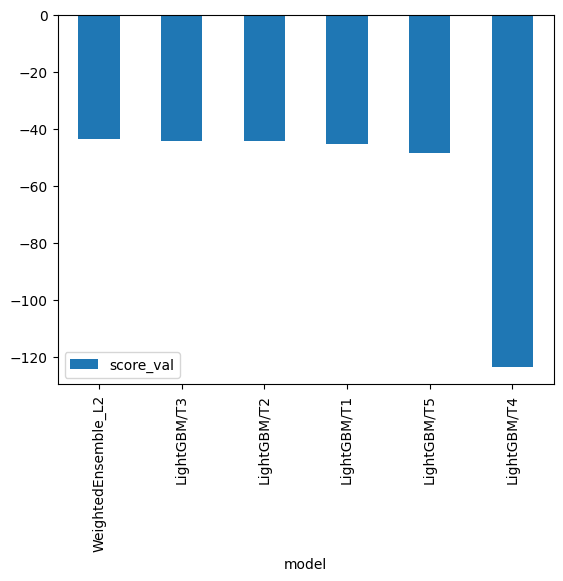

In [50]:
predictor_new_hpo.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

In [51]:
hpo_best_model_score = predictor_new_hpo.leaderboard(silent=True).score_val[0]
hpo_best_model_score

-43.48642518939267

In [52]:
hpo_best_model = predictor_new_hpo.leaderboard(silent=True).model[0]
hpo_best_model

'WeightedEnsemble_L2'

In [54]:
#hpo2
predictions_new_hpo = predictor_new_hpo.predict(test_new_feat)
predictions_new_hpo.head()

0    17.183256
1     9.089851
2     4.937253
3     4.937253
4     4.937253
Name: count, dtype: float32

In [56]:
#hpo2
predictions_new_hpo.describe()

count    6493.000000
mean      182.854645
std       160.421509
min        -2.774205
25%        48.479568
50%       148.598038
75%       265.589752
max       857.163940
Name: count, dtype: float64

In [57]:
predictions_new_hpo[predictions_new_hpo < 0].count()

17

In [58]:
predictions_new_hpo[predictions_new_hpo < 0] = 0

In [59]:
submission_new_hpo = pd.read_csv('/Users/christina/aws_ml_nano/cd0385-project-starter/project/bike-sharing-demand/sampleSubmission.csv', parse_dates=['datetime'])
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [60]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:01<00:00, 121kB/s]
Successfully submitted to Bike Sharing Demand

In [61]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2023-03-15 20:49:20  new features with hyperparameters  complete  0.58178      0.58178       
submission_new_features.csv  2023-03-15 20:41:00  new features                       complete  0.49843      0.49843       
submission.csv               2023-03-15 20:07:22  first raw submission               complete  1.82268      1.82268       
submission_new_hpo.csv       2023-03-08 00:18:14  new features with hyperparameters  complete  0.57948      0.57948       


#### New Score of `0.58178`

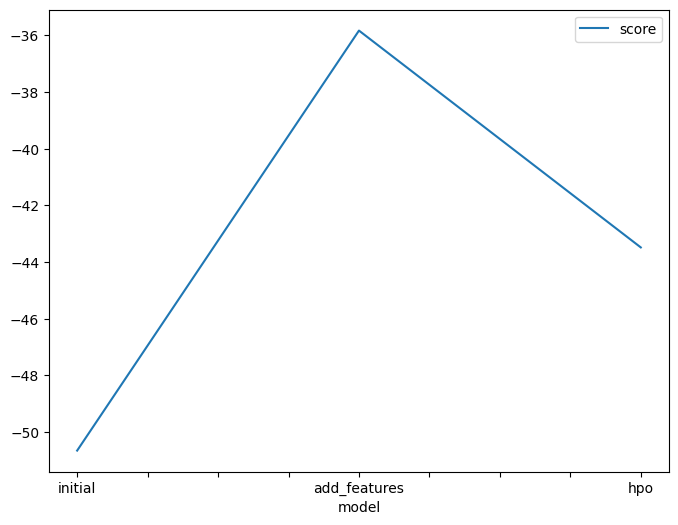

In [62]:
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [initial_best_model_score, new_feature_best_model_score, hpo_best_model_score]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

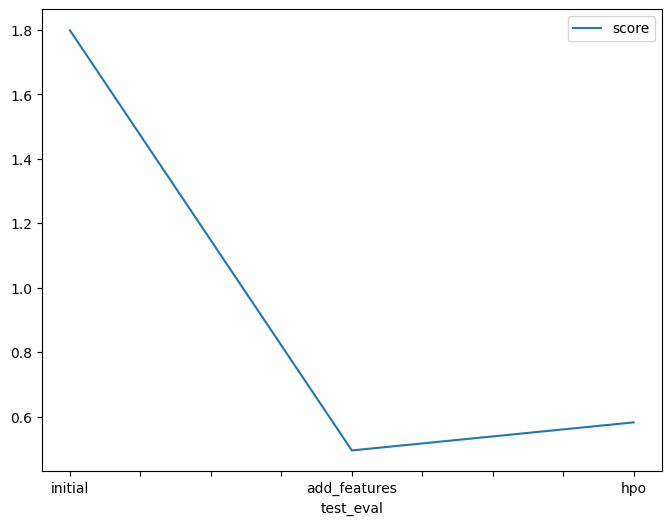

In [63]:
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.79873, 0.49462, 0.58178]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [68]:
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ["default", "default", hyperparameters],
    "hpo2": ["default", "default", hyperparameters2],
    "hpo3": ["default", "default", hyperparameters3],
    "score": [1.79873, 0.49462, 0.58178]
})

,model,hpo1,hpo2,hpo3,score
0,initial,default,default,default,1.79873
1,add_features,default,default,default,0.49462
2,hpo,"{'GBM': {'num_boost_round': 100, 'num_leaves': Int: lower=26, upper=66}, 'NN': {'num_epochs': 10, 'learning_rate': Real: lower=1e-05, upper=10.0, 'activation': ['relu', 'softrelu', 'leakyrelu'], 'layers': [[100], [1000], [200, 100], [300, 200, 100]], 'dropout_prob': Real: lower=0.0, upper=0.5}, 'XGB': {'eta': Real: lower=1e-05, upper=10.0, 'max_depth': Int: lower=2, upper=10, 'sampling_method': ['uniform', 'gradient_based']}, 'RF': {'max_depth': Int: lower=10, upper=100, 'max_features': ['log2', 'sqrt'], 'min_samples_leaf': Int: lower=1, upper=5, 'min_samples_split': Int: lower=2, upper=10...","{'GBM': {'num_boost_round': 100, 'num_leaves': Int: lower=26, upper=66}, 'NN': {'num_epochs': 10, 'learning_rate': Real: lower=1e-05, upper=10, 'activation': ['relu', 'softrelu', 'leakyrelu'], 'layers': [[100], [1000], [200, 100], [300, 200, 100]], 'dropout_prob': Real: lower=0.0, upper=0.5}}","{'FASTAI': {'num_epochs': 10, 'learning_rate': Real: lower=0.0001, upper=0.01, 'activation': ['relu', 'softrelu', 'tanh'], 'dropout_prob': Real: lower=0.0, upper=0.5}, 'GBM': {'num_boost_round': 100, 'num_leaves': Int: lower=40, upper=66}, 'CAT': {'learning_rate': Real: lower=0.0001, upper=0.01}}",0.58178
